# CNN-LSTM Model Training

## Import Common Libraries

In [1]:
import numpy as np

## Define paths

In [2]:
cnn_lstm_features_dir = "../data/features/audio_16k/augmented_mfcc+deltas_mel-spectrograms_spectral_prosodic/audio_features"
metadata_dir = "../data/features/audio_16k/augmented_mfcc+deltas_mel-spectrograms_spectral_prosodic/metadata.csv"
checkpoints_model_dir = "../models/cnn-lstm/checkpoints"
final_model_dir = "../models/cnn-lstm/final"

## Ensure dir exist

In [3]:
import os

os.makedirs(checkpoints_model_dir, exist_ok=True)
os.makedirs(final_model_dir, exist_ok=True)

## Load Metadata

In [4]:
import pandas as pd

df = pd.read_csv(metadata_dir)
print(f"Total samples: {len(df)}")

Total samples: 56590


## Encode labels for CNN

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Prepare labels
le = LabelEncoder()
y_int = le.fit_transform(df['emotion'])      # convert emotions to integers
y_onehot = to_categorical(y_int) # one-hot encoding for softmax

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(le.classes_)
inverse_map = {idx: cls for idx, cls in enumerate(le.classes_)}

print("Number of classes:", num_classes)
print(inverse_map)

2025-12-02 03:30:07.763788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 03:30:07.808242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 03:30:08.907596: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of classes: 6
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}


## Train/test split

In [6]:
from sklearn.model_selection import train_test_split

file_paths = df['file_path'].values

train_paths, test_paths, y_train, y_test = train_test_split(
    file_paths, y_onehot, test_size=0.2, stratify=y_int, random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 45272
Test samples: 11318


## Create Generators

In [7]:
import sys
sys.path.append("../src")
import classes
from classes import AudioDataGenerator

train_gen = AudioDataGenerator(train_paths, y_train, batch_size=32, shuffle=True)
test_gen = AudioDataGenerator(test_paths, y_test, batch_size=32, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

Training batches per epoch: 1415
Test batches: 354


## Define CNN-LSTM Architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input, LSTM, Reshape

input_shape = (261, 150, 1)

model = Sequential([
    Input(input_shape),

    # BLOCK 1: Early features
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 2: Mid-level features
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 3: High-level features
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # Reshape for LSTM
    Reshape((32, 18 * 128)),

    # LSTM Layers
    LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2), 
    LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.2), 

    # CLASSIFICATION
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

I0000 00:00:1764617409.695443    8720 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Compile the model

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    ), # Stops training if there is no improvement in 10 epochs
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7
    ), # Reduces learning rate if there is no improvement on val_loss
    ModelCheckpoint(
        filepath=f"{checkpoints_model_dir}/best_cnn_model.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        mode="max", 
        verbose=1
    ) # Saves the best model in the training
]

## Train the Model

In [10]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


E0000 00:00:1764617416.349251    8720 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-12-02 03:30:17.274098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-02 03:30:19.417184: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 03:30:20.453311: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more

 645/1415 ━━━━━━━━━━━━━━━━━━━━ 8:53 693ms/step - accuracy: 0.1656 - loss: 2.3579

2025-12-02 03:37:50.720917: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 03:37:51.285913: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 03:37:52.016972: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1415/1415 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.1677 - loss: 2.1725
Epoch 1: val_accuracy improved from None to 0.22133, saving model to ../models/cnn-lstm/checkpoints/best_cnn_model.keras


2025-12-02 03:47:59.688078: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1415/1415 ━━━━━━━━━━━━━━━━━━━━ 1069s 747ms/step - accuracy: 0.1741 - loss: 1.9555 - val_accuracy: 0.2213 - val_loss: 1.7494 - learning_rate: 5.0000e-04
Epoch 2/100
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.2540 - loss: 1.7002
Epoch 2: val_accuracy improved from 0.22133 to 0.39751, saving model to ../models/cnn-lstm/checkpoints/best_cnn_model.keras
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 1053s 744ms/step - accuracy: 0.2933 - loss: 1.6264 - val_accuracy: 0.3975 - val_loss: 1.4388 - learning_rate: 5.0000e-04
Epoch 3/100
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.3884 - loss: 1.4598
Epoch 3: val_accuracy improved from 0.39751 to 0.40802, saving model to ../models/cnn-lstm/checkpoints/best_cnn_model.keras
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 1050s 742ms/step - accuracy: 0.4060 - loss: 1.4252 - val_accuracy: 0.4080 - val_loss: 1.3978 - learning_rate: 5.0000e-04
Epoch 4/100
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.4779 - loss: 1.3009
Epoch 4: val_accuracy i

## Make Predictions

In [11]:
# Predict probabilities
y_pred_prob = model.predict(test_gen)

# Convert to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels as class indices
y_true = np.argmax(y_test, axis=1)

354/354 ━━━━━━━━━━━━━━━━━━━━ 51s 139ms/step


## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

Accuracy: 0.9342
Weighted Precision: 0.9344
Weighted Recall: 0.9342
Weighted F1-score: 0.9341


### Confusion Matrix

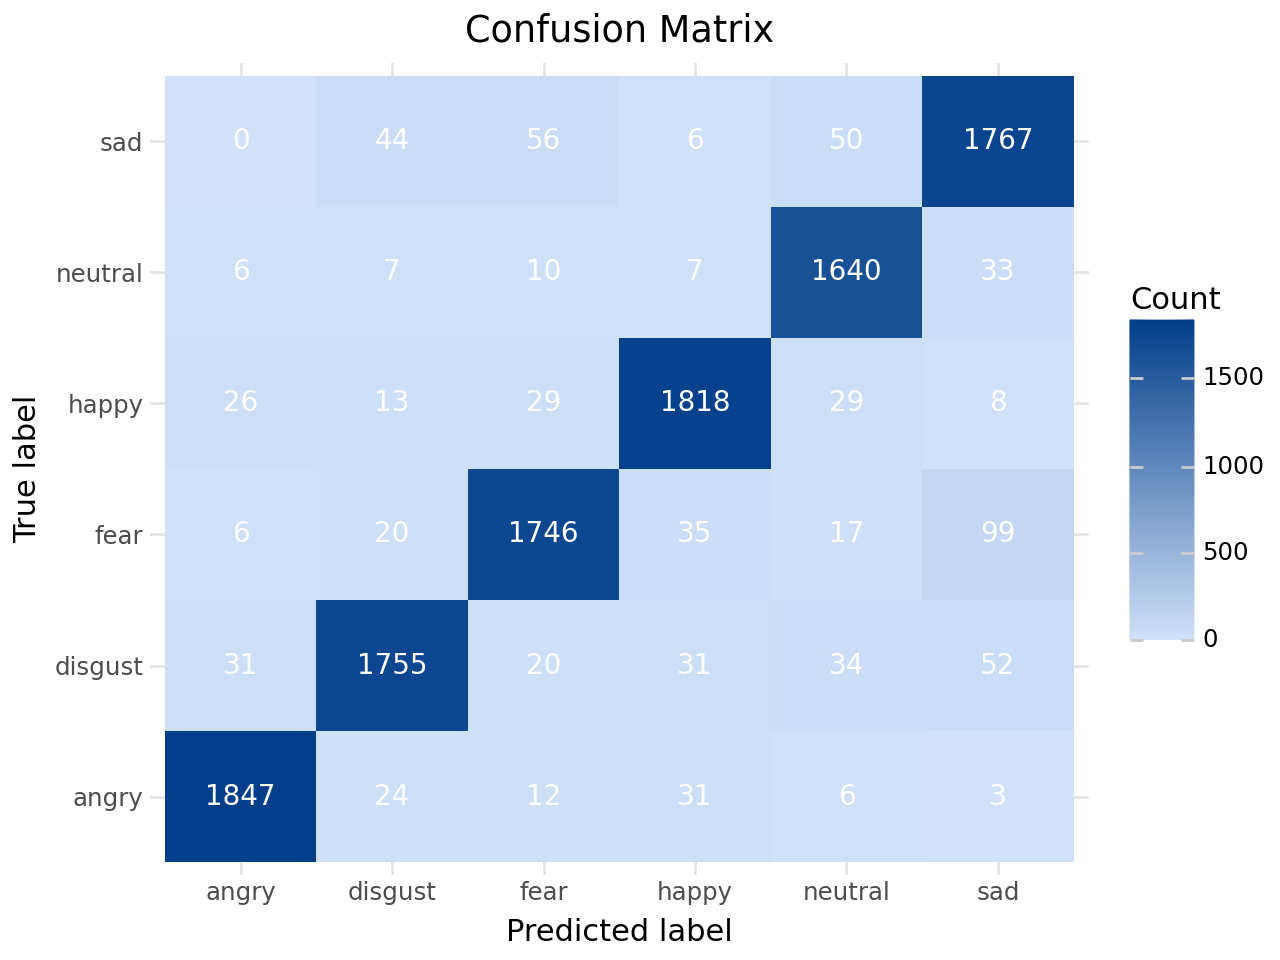

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert numeric labels → emotion names
true_labels = [inverse_map[i] for i in y_true]
pred_labels = [inverse_map[i] for i in y_pred]

# Compute confusion matrix
labels = sorted(list(inverse_map.values()))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [14]:
uar = recall_score(y_true, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

Unweighted Average Recall (UAR): 0.9347


### Detailed classification report

In [15]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96      1923
     disgust       0.94      0.91      0.93      1923
        fear       0.93      0.91      0.92      1923
       happy       0.94      0.95      0.94      1923
     neutral       0.92      0.96      0.94      1703
         sad       0.90      0.92      0.91      1923

    accuracy                           0.93     11318
   macro avg       0.93      0.93      0.93     11318
weighted avg       0.93      0.93      0.93     11318



### Save Model

In [16]:
model.save("../models/cnn-lstm/final/cnn-lstm-ser-model.keras")